In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline
from tqdm import tqdm
import gradio as gr


In [3]:
# Load previously saved DataFrames
business_df = pd.read_parquet("../Data/business_df.parquet")
review_df = pd.read_parquet("../Data/review_df.parquet")

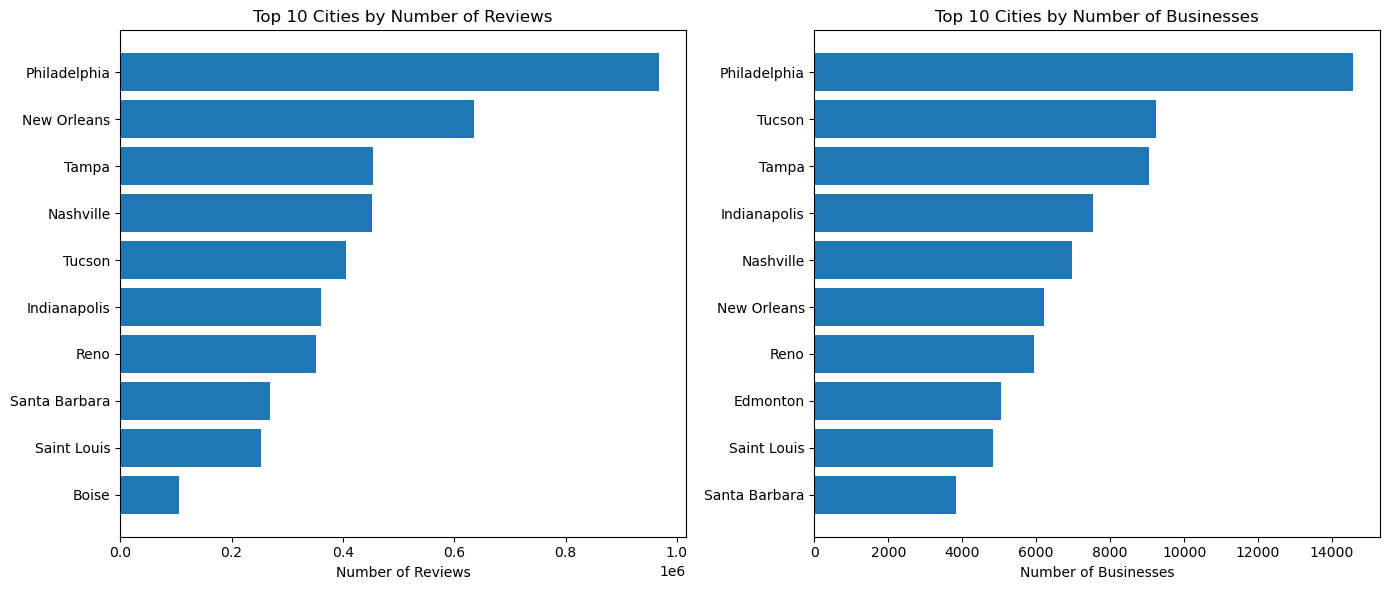

In [4]:
# Count businesses per city
business_counts = business_df.groupby('city')['business_id'].nunique().reset_index(name='num_businesses')

# Merge review data with business to get city info
review_with_city = pd.merge(
    review_df[['business_id', 'review_id']],
    business_df[['business_id', 'city']],
    on='business_id',
    how='left'
)

# Count reviews per city
review_counts = review_with_city.groupby('city')['review_id'].count().reset_index(name='num_reviews')

# Combine
city_stats = pd.merge(business_counts, review_counts, on='city')
city_stats['reviews_per_business'] = city_stats['num_reviews'] / city_stats['num_businesses']

# Plotting
top_by_reviews = city_stats.sort_values(by='num_reviews', ascending=False).head(10)
top_by_businesses = city_stats.sort_values(by='num_businesses', ascending=False).head(10)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.barh(top_by_reviews['city'][::-1], top_by_reviews['num_reviews'][::-1])
plt.title('Top 10 Cities by Number of Reviews')
plt.xlabel('Number of Reviews')

plt.subplot(1, 2, 2)
plt.barh(top_by_businesses['city'][::-1], top_by_businesses['num_businesses'][::-1])
plt.title('Top 10 Cities by Number of Businesses')
plt.xlabel('Number of Businesses')

plt.tight_layout()
plt.show()


In [5]:
# Filter Philadelphia restaurants
philly_businesses = business_df[
    (business_df['city'].str.lower() == 'philadelphia') &
    (business_df['categories'].fillna('').str.contains("Restaurants", case=False))
]
philly_ids = set(philly_businesses['business_id'])

# Filter reviews and sample 3000
philly_reviews = review_df[review_df['business_id'].isin(philly_ids)].dropna(subset=["text"])
sample_reviews = philly_reviews.sample(n=3000, random_state=42).reset_index(drop=True)


In [ ]:
# Load model
print("Loading model...")
classifier = pipeline("zero-shot-classification", model="typeform/distilbert-base-uncased-mnli", device=-1)
print("Model loaded.")

# Moods
mood_labels = [
    "adventurous", "comforting", "energizing", "romantic",
    "cozy", "festive", "indulgent", "refreshing"
]

# Efficient batch classification
def batch_classify(texts, batch_size=16):
    results = []
    for i in tqdm(range(0, len(texts), batch_size), desc="⚡ Classifying"):
        batch = texts[i:i + batch_size]
        try:
            res = classifier(batch, candidate_labels=mood_labels, multi_label=True, truncation=True)
            results.extend(res)
        except Exception as e:
            print(f" Error at batch {i}: {e}")
            results.extend([{'labels': [], 'scores': []}] * len(batch))
    return results

# Apply classification
sample_reviews['mood_scores'] = [dict(zip(r["labels"], r["scores"])) if r["labels"] else {} for r in batch_classify(sample_reviews['text'].tolist())]


🔄 Loading model...


The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
Device set to use cpu


✅ Model loaded.


⚡ Classifying: 100%|██████████| 188/188 [1:01:08<00:00, 19.51s/it]


In [ ]:
# Compute average mood scores per business
def average_mood_scores(df):
    mood_sums = {}
    count = len(df)
    for mood_dict in df['mood_scores']:
        if isinstance(mood_dict, dict):
            for mood, score in mood_dict.items():
                mood_sums[mood] = mood_sums.get(mood, 0) + score
    return {mood: mood_sums[mood] / count for mood in mood_sums}

mood_by_business = (
    sample_reviews.groupby('business_id')
    .apply(average_mood_scores)
    .reset_index(name='aggregated_moods')
)

# Assign top mood
def get_top_mood_and_score(mood_dict):
    if isinstance(mood_dict, dict) and mood_dict:
        top_mood = max(mood_dict.items(), key=lambda x: x[1])
        return pd.Series({'top_mood': top_mood[0], 'top_mood_score': top_mood[1]})
    return pd.Series({'top_mood': None, 'top_mood_score': None})

mood_by_business[['top_mood', 'top_mood_score']] = mood_by_business['aggregated_moods'].apply(get_top_mood_and_score)

# Merge with stars/review count and calculate final score
mood_by_business = pd.merge(mood_by_business, philly_businesses[['business_id', 'stars', 'review_count']], on='business_id', how='left')
mood_by_business['final_score'] = mood_by_business['top_mood_score'] * mood_by_business['stars'] * mood_by_business['review_count']

# Filter to only valid restaurants and get top 1 per mood
mood_by_business = mood_by_business[mood_by_business['business_id'].isin(philly_businesses['business_id'])]
top_restaurants = (
    mood_by_business.sort_values(by='final_score', ascending=False)
    .dropna(subset=['top_mood'])
    .drop_duplicates(subset=['top_mood'])
    .set_index('top_mood')
)


In [8]:
def get_restaurant_details(selected_mood):
    print(f"🔍 Getting restaurant for mood: {selected_mood}")
    
    if selected_mood not in top_restaurants.index:
        return f"No restaurant found for mood '{selected_mood}'."

    top = top_restaurants.loc[selected_mood]
    biz_id = top['business_id']

    # Lookup business info
    biz = philly_businesses[philly_businesses['business_id'] == biz_id].iloc[0]
    name, address, stars, review_count, categories = biz['name'], biz['address'], biz['stars'], biz['review_count'], biz['categories']

    # Top 3 reviews with that mood
    reviews = sample_reviews[sample_reviews['business_id'] == biz_id]
    matching_reviews = reviews[reviews['mood_scores'].apply(lambda d: isinstance(d, dict) and selected_mood in d)]
    matching_reviews["score"] = matching_reviews["mood_scores"].apply(lambda d: d[selected_mood])
    top_reviews = matching_reviews.sort_values(by="score", ascending=False).head(3)

    review_texts = "\n\n".join([
        f"⭐ {row['stars']}: {row['text'][:500]}..." for _, row in top_reviews.iterrows()
    ])

    return f"""
## 🍽️ {name}
**📍 Address**: {address}  
**⭐ Rating**: {stars} stars from {review_count} reviews  
**📂 Categories**: {categories}  

### 🧠 Why we picked it:
This restaurant had the highest `{selected_mood}` mood score from our model!

---

### 💬 Top Reviews Matching Your Mood:

{review_texts if review_texts else 'No matching reviews found.'}
"""
